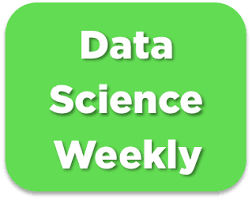

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score,RocCurveDisplay,roc_curve
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


# Explore dataset

***Pandas profiling without sampling***

In [6]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


In [6]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000,random_state=0)

In [7]:
data_sample.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

***Histplot categorical variables***

<AxesSubplot:xlabel='country', ylabel='Count'>

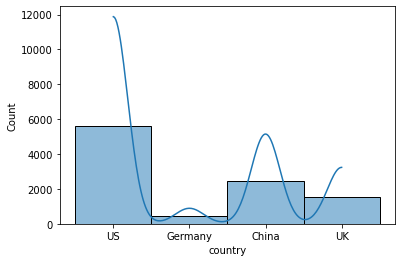

In [8]:
sns.histplot(x=data_sample.country,kde=True)

<AxesSubplot:xlabel='new_user', ylabel='Count'>

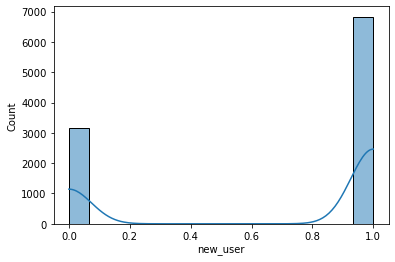

In [9]:
sns.histplot(x=data_sample.new_user,kde=True)

<AxesSubplot:xlabel='source', ylabel='Count'>

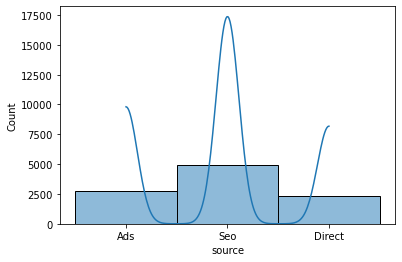

In [10]:
sns.histplot(x=data_sample.source,kde=True)

***Numerical/Continous Variables Visualizations*** 

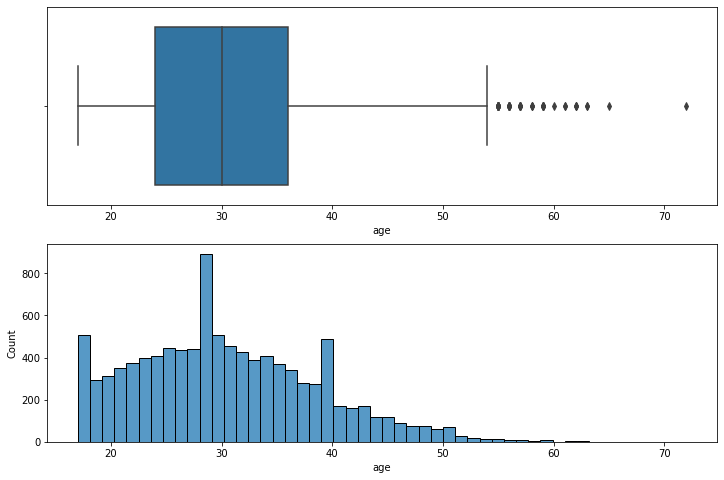

In [11]:
fig, ax =plt.subplots(nrows=2,ncols=1,figsize=(12,8))
sns.boxplot(x=data_sample.age,ax=ax[0])
sns.histplot(x=data_sample.age,ax=ax[1])
plt.show()


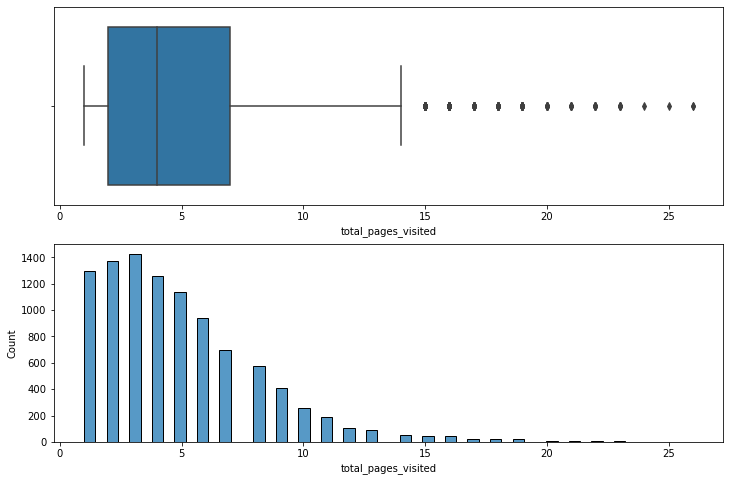

In [12]:
fig, ax =plt.subplots(nrows=2,ncols=1,figsize=(12,8))
sns.boxplot(x=data_sample.total_pages_visited,ax=ax[0])
sns.histplot(x=data_sample.total_pages_visited,ax=ax[1])
plt.show()

***Relationship with the target variable***

<AxesSubplot:xlabel='country', ylabel='Count'>

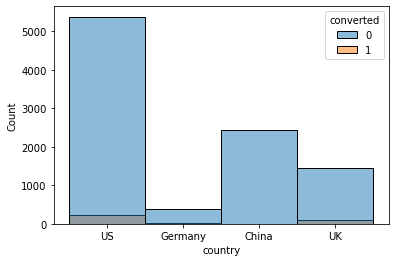

In [13]:
sns.histplot(data=data_sample,x="country",hue="converted")

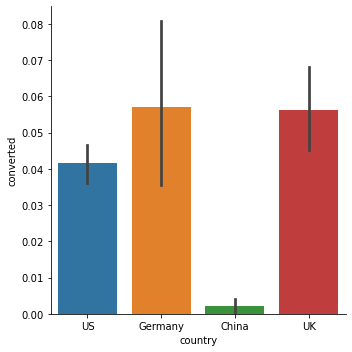

In [14]:
sns.catplot(x="country", y="converted", kind="bar",data=data_sample)

<AxesSubplot:xlabel='new_user', ylabel='Count'>

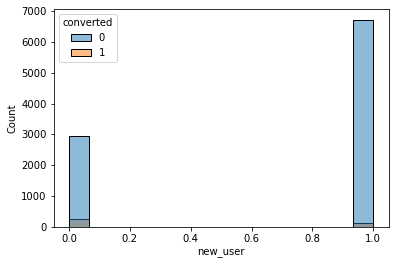

In [15]:
sns.histplot(data=data_sample,x="new_user",hue="converted")

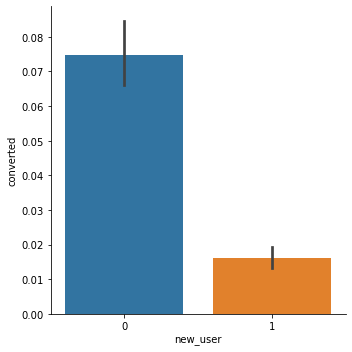

In [16]:
sns.catplot(x="new_user", y="converted", kind="bar", data=data_sample)

<AxesSubplot:xlabel='source', ylabel='Count'>

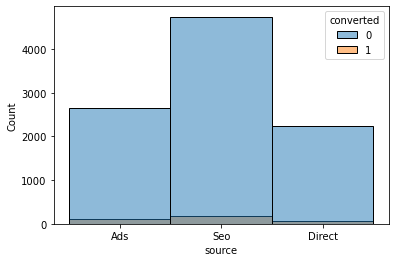

In [17]:
sns.histplot(data=data_sample,x="source",hue="converted")

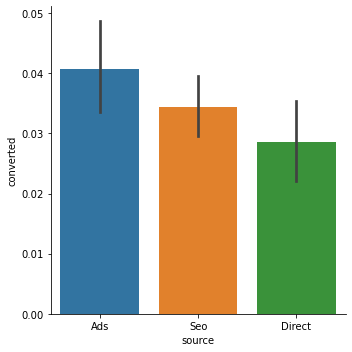

In [18]:
sns.catplot(x="source", y="converted", kind="bar", data=data_sample)

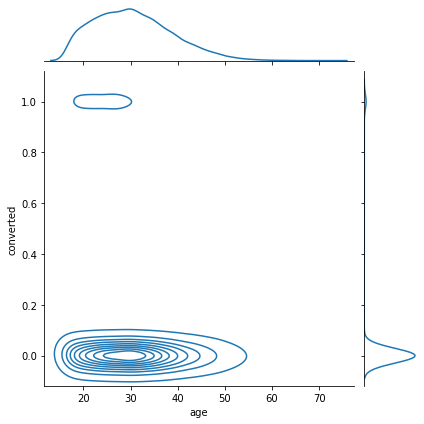

In [19]:
sns.jointplot(data=data_sample, y="converted", x="age",kind="kde")

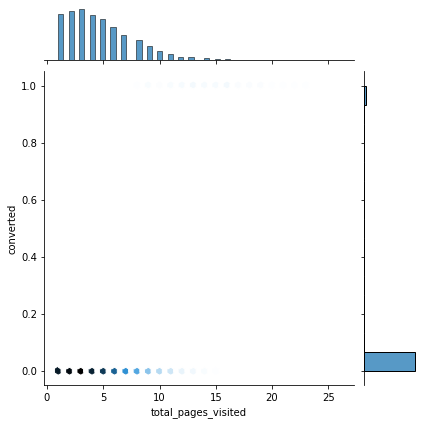

In [20]:
sns.jointplot(data=data_sample, y="converted", x="total_pages_visited",kind="hex")

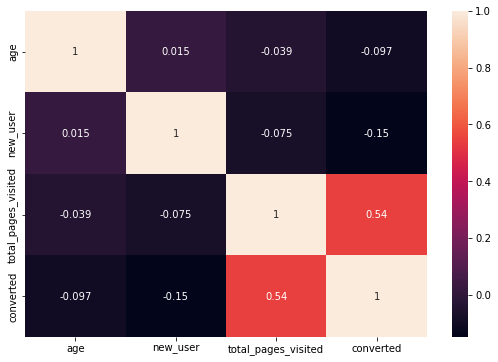

In [21]:
corr=data_sample.corr()
corr
f, ax = plt.subplots(figsize=(9, 6)) # create a "sheet" to have bigger graph
sns.heatmap(corr, annot=True, ax=ax);

# Make your model

## Choose variables to use in the model, and create train and test sets


In [22]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [23]:
numeric_indices = [1,4]
categorical_indices = [0,2,3]
target_variable = 'converted'

In [56]:
X = data.drop(columns=target_variable,axis=1)
Y = data[target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [25]:
X.head()

,country,age,new_user,source,total_pages_visited
0,China,22,1,Direct,2
1,UK,21,1,Ads,3
2,Germany,20,0,Seo,14
3,US,23,1,Seo,3
4,US,28,1,Direct,3


In [26]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [27]:
print("Train Data Frame Shape",X_train.shape,len(Y_train))
print("Test Data Frame Shape",X_test.shape,len(Y_test))

Train Data Frame Shape (227664, 5) 227664
Test Data Frame Shape (56916, 5) 56916


In [28]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")


Convert pandas DataFrames to numpy arrays...
...Done


## Training pipeline

In [29]:
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))])

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer( 
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat-1', categorical_transformer, categorical_indices)
    ])


In [30]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print()


Performing preprocessings on train set...
...Done.



In [31]:
# Train model
print("Train model...")
classifier = AdaBoostClassifier() 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [32]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [33]:
scores=cross_val_score(classifier,X_train,Y_train,cv=5,scoring="f1")
print(scores)
print(scores.mean())


[0.74656489 0.73858268 0.75822928 0.76385725 0.73289011]
0.748024840897265


## Test pipeline

In [34]:
# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) 
print('...Done.')
print()

Performing preprocessings on test set...
...Done.



In [35]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [36]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7575872247029442
f1-score on test set :  0.7481146304675715


***Less overfit than the Random Forest***

Confusion matrix on train set : 


C:\Users\saas1\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


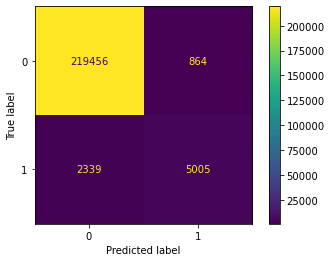

In [38]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
plot_confusion_matrix(classifier, X_train,Y_train) 
print()


Confusion matrix on test set : 


C:\Users\saas1\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


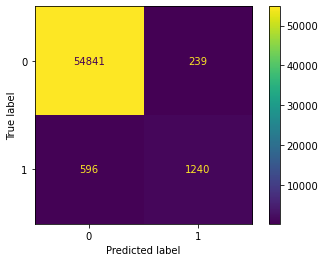

In [39]:
print("Confusion matrix on test set : ")
plot_confusion_matrix(classifier, X_test,Y_test) 
print()

**Our baseline model reaches a f1-score of 80%. Now, I will refine my model and try to beat this score ! 🚀🚀**

In [44]:
#params= {'n_estimators':[200,250,300,350,400,450,500,550]}

params= {'n_estimators':[200,300,350]}

In [45]:
ab=AdaBoostClassifier()

grid_search=GridSearchCV(estimator=ab,param_grid=params,cv=5,verbose=2,scoring="f1")
grid_search.fit(X_train, Y_train)
print("...Done.")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...................................n_estimators=200; total time=  31.3s
[CV] END ...................................n_estimators=200; total time=  32.4s
[CV] END ...................................n_estimators=200; total time=  33.2s
[CV] END ...................................n_estimators=200; total time=  32.0s
[CV] END ...................................n_estimators=200; total time=  30.5s
[CV] END ...................................n_estimators=300; total time=  46.8s
[CV] END ...................................n_estimators=300; total time=  46.3s
[CV] END ...................................n_estimators=300; total time=  45.6s
[CV] END ...................................n_estimators=300; total time=  45.2s
[CV] END ...................................n_estimators=300; total time=  45.3s
[CV] END ...................................n_estimators=350; total time=  52.7s
[CV] END ...................................n_est

In [48]:
print("Best hyperparameters : ", grid_search.best_params_)
print("Best F1 score : ", grid_search.best_score_)
print("Best estimator : ", grid_search.best_estimator_)

Best hyperparameters :  {'n_estimators': 300}
Best F1 score :  0.7647298081394456
Best estimator :  AdaBoostClassifier(n_estimators=300)


***Create the ADAboost Classifier with the best hyperparameters***

In [57]:
ab_final=AdaBoostClassifier(n_estimators=300)

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [58]:
X = X.values
Y = Y.values

In [59]:
X

array([['China', 22, 1, 'Direct', 2],
       ['UK', 21, 1, 'Ads', 3],
       ['Germany', 20, 0, 'Seo', 14],
       ...,
       ['US', 41, 1, 'Seo', 5],
       ['US', 31, 1, 'Direct', 4],
       ['US', 26, 0, 'Ads', 3]], dtype=object)

In [60]:
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))])

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer( 
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat-1', categorical_transformer, categorical_indices)
    ])


# Preprocessings on X 
print("Performing preprocessings on X total dataset...")
X= preprocessor.fit_transform(X)
print('...Done.')
print()

Performing preprocessings on X total dataset...
...Done.



In [61]:
ab_final.fit(X,Y)

AdaBoostClassifier(n_estimators=300)

In [62]:
Y_train_pred_final = ab_final.predict(X)

print("f1-score on train set : ", f1_score(Y, Y_train_pred_final))


f1-score on train set :  0.7637372579769589


Confusion matrix on X total dataset : 


C:\Users\saas1\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


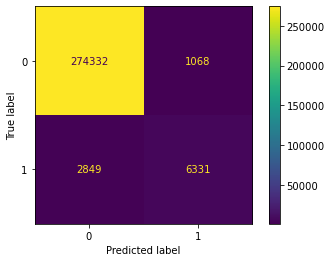

In [63]:
print("Confusion matrix on X total dataset : ")
plot_confusion_matrix(ab_final, X,Y) 
print()

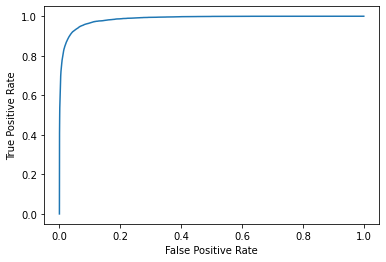

In [64]:
y_score=ab_final.predict_proba(X)[:,1]

fpr, tpr, _ = roc_curve(Y, y_score, pos_label=ab_final.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [65]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [66]:
data_without_labels.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [67]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = data_without_labels.values
print("...Done")

Convert pandas DataFrames to numpy arrays...
...Done


In [68]:
# Preprocessings on X without labels set
print("Performing preprocessings on X without labels set...")
X_without_labels = preprocessor.transform(X_without_labels)
print('...Done.')
print()

Performing preprocessings on X without labels set...
...Done.



In [69]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': ab_final.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('3-conversion_data_test_predictions_ADABoost_SA.csv', index=False)
print(Y_predictions.shape)

(31620, 1)
